[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-labs/cookbook/blob/main/gen-ai/openai/agents-sdk-intro.ipynb)


## OpenAI's Agents SDK

OpenAI have released an **Agents SDK**, their version of an open source agent development library.

OpenAI have outlined a few features of the library:

```
* Agent loop: Built-in agent loop that handles calling tools, sending results to the LLM, and looping until the LLM is done.
* Python-first: Use built-in language features to orchestrate and chain agents, rather than needing to learn new abstractions.
* Handoffs: A powerful feature to coordinate and delegate between multiple agents.
* Guardrails: Run input validations and checks in parallel to your agents, breaking early if the checks fail.
* Function tools: Turn any Python function into a tool, with automatic schema generation and Pydantic-powered validation.
* Tracing: Built-in tracing that lets you visualize, debug and monitor your workflows, as well as use the OpenAI suite of evaluation, fine-tuning and distillation tools.
```

([source](https://openai.github.io/openai-agents-python/))

**Note**: this notebook is inspired by this [Agents SDK intro](https://github.com/aurelio-labs/cookbook/blob/main/gen-ai/openai/agents-sdk-intro.ipynb) notebook and adapted to my Online Bank's [Customer Onboarding Case](https://github.com/BittnerPierre/AI-Agent-Casebook)

Original notebook focus on covering the essentials - including the **agent loop**, **python-first**, **guardrails**, **streaming** and **function tools** features.

This version has been extended to : 

- **File Search Tool** (RAG Agent), 
- **Handsoffs**, 
- **Context Management**, 
- **Agent Visualization**, 
- **Tracing**, 
- **Dynamic Instructions**

What are we building to day: 

<img src="../res/Schema_Fonctionnel.png" alt="schema" width="400"  style="background-color: white; padding: 5px;"/>

Note: DB access is not covered in this notebook.

Let's start by installing the library:

In [1]:
#!pip install -qU openai-agents==0.0.9 openai-agents[viz] 
## requires libraries  graphviz (brew install graphviz)

First let's set our [OpenAI API key](https://platform.openai.com/settings/organization/api-keys).

Note: I'm using .env file.

In [2]:
import os
from getpass import getpass
from dotenv import load_dotenv, find_dotenv

# Import key from .env
_ = load_dotenv(find_dotenv())

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Agent definition

In [3]:
from agents import Agent, Runner

agent = Agent(
    name="customer_support_agent",
    instructions="You're a helpful customer onboarding AI assistant for an online bank. "
      "Your goal is to answer questions on products and services offered by the company"
      " AND to solve issues with web and mobile app during onboarding process."
      " Answer by a single sentence whenever possible.",
    model="gpt-4o-mini",
)

## Running our Agent

OpenAI gives us three methods for running our agent, all via a `Runner` class — those methods are:

1. `Runner.run()` which runs in async.
2. `Runner.run_sync()` which runs in sync.
3. `Runner.run_streamed()` which runs in async _and_ streams the response back to us.

We'll quicky test method **(1)**:

In [4]:
result = await Runner.run(
    starting_agent=agent,
    input="What is the difference between a CREDIT card and a DEBIT card?"
)
result.final_output

'A credit card allows you to borrow money up to a certain limit to make purchases, while a debit card withdraws funds directly from your bank account.'

In most scenarios we'll likely want to be using method **(3)**, ie running async and streaming tokens. To do this we need to write a little more code to handle the async streaming and print the tokens as they're returned.

First, we create a `RunResultStreaming` object by calling `Runner.run_streamed(...)`, we then _asynchronously_ iterate through the streamed events returned by our LLM using the `response.stream_events()` method:

In [5]:
response = Runner.run_streamed(
    starting_agent=agent,
    input="Bonjour, je dois ouvrir un compte bancaire rapidement."
)
async for event in response.stream_events():
    print(event)

AgentUpdatedStreamEvent(new_agent=Agent(name='customer_support_agent', instructions="You're a helpful customer onboarding AI assistant for an online bank. Your goal is to answer questions on products and services offered by the company AND to solve issues with web and mobile app during onboarding process. Answer by a single sentence whenever possible.", handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True), type='agent_updated_stream_event')
RawResponsesStreamEvent(data=ResponseCreatedEvent(response=Response(id='resp_67f7e7fd53e881929c22dc04cad6fe640adcfaa9cc6fd900', created_at=17443000

We can filter these various event types to find only raw tokens like so:

In [6]:
from openai.types.responses import ResponseTextDeltaEvent

# we do need to reinitialize our runner before re-executing
response = Runner.run_streamed(
    starting_agent=agent,
    input="Bonjour, je dois ouvrir un compte bancaire rapidement."
)

async for event in response.stream_events():
    if event.type == "raw_response_event" and \
        isinstance(event.data, ResponseTextDeltaEvent):
        print(event.data.delta, end="", flush=True)

Bonjour ! Vous pouvez ouvrir un compte bancaire en ligne en remplissant notre formulaire d'inscription sur le site ou l'application mobile.

## Tools

OpenAI included **function tools** as a key feature in their Agents SDK announcement. After turning everyone away from using _function calling_ to instead use _tool calling_, OpenAI have now decided that an LLM deciding to execute some code will be called _"function tools"_.

To use _function tools_ in Agents SDK we simply decorate a function with the `@function_tool` decorator like so:

In [7]:
from agents import function_tool

@function_tool
def eligibility_checker(
    nationality: str,
    age: int,
    has_eu_bank_account: bool
) -> str:
    """
    Checks if the user is eligible to open an account.

    - nationality: nationality (e.g., 'French', 'Belgian', etc.).
    - age: age in years.
    - has_eu_bank_account: True/False if the user already has
    a bank account in an EU country.

    Return: a text indicating "Eligible" or "Not Eligible".
    """

    # Règles simplifiées, vous adaptez à la réalité
    # 1. Être majeur (>=18 ans)
    # 2. Être de nationalité d'un pays de l'UE (on se limite à un set)
    # 3. Posséder déjà un compte bancaire dans l'UE

    EU_NATIONALITIES = {
        "française", "francais", "french", "belgium", "belge", "allemande", "german", "italienne", "italian",
        "espagnole", "spanish", "portugaise", "luxembourgeoise",  # etc.
    }

    # Convertir pour simplifier la comparaison
    nat_lower = nationality.lower().replace(" ", "")

    if age < 18:
        return "Non Eligible : l'utilisateur doit être majeur."
    if nat_lower not in EU_NATIONALITIES:
        return "Non Eligible : la nationalité doit être européenne."
    if not has_eu_bank_account:
        return "Non Eligible : l'utilisateur doit posséder un compte bancaire dans l'UE."
    
    return "Eligible"

Note that we have taken extra care to include a clear and descriptive function name, relatively clear parameter names, type annotations for both input parameters and expected output, and a natural language docstring that will be fed to the LLM and explain to it _what_ this tool does.

To run our agent _with_ tools we simply pass our new tool into the `tools` parameter during `Agent` initialization.

In [8]:
agent = Agent(
    name="customer_support_agent",
    instructions=(
        "You are an AI assistant in charge of customer onboarding for an online bank.\n"
        "You answer questions about offers and services.\n"
        "You can also verify a prospect's eligibility.\n"
        "For this, call the eligibility checker function if the user "
        "provides information about their nationality, age and whether they have "
        "a European bank account.\n"
        "DO NOT invent additional rules.\n"
        "If the user is eligible, indicate it clearly, otherwise explain the reason.\n"
        "Never reveal the exact function name or its internal logic.\n"
    ),
    model="gpt-4o-mini",
    tools=[eligibility_checker]  # note that we expect a list of tools
)

Now let's initialize a new runner and execute our agent with tools:

In [9]:
from agents import Runner


result = await Runner.run(
    starting_agent=agent,
    input="Salut, je suis français, j'ai 25 ans et j'ai déjà un compte en Belgique. Suis-je éligible ?"
)
print("Final response:\n", result.final_output)

Final response:
 Malheureusement, vous n'êtes pas éligible pour ouvrir un compte. Bien que vous soyez Français, il semble que la nationalité doit être d'un autre pays européen. Si vous avez d'autres questions ou si vous souhaitez plus d'informations, n'hésitez pas à demander !


#### WorkFlow

1. The agent reads the request.
1. It sees it can call eligibility_checker with nationality="French", age=25, has_eu_bank_account=True.
1. The function returns "Eligible".

The agent sends back to the user a message like "Yes, you are eligible..."

In [10]:
conversation = [
    {"role": "user", "content": "Salut, je suis français, j'ai 25 ans et j'ai déjà un compte au Canada. Suis-je éligible ?"}
]

response = Runner.run_streamed(
    starting_agent=agent,
    input=conversation
)
async for event in response.stream_events():
    print(event)

AgentUpdatedStreamEvent(new_agent=Agent(name='customer_support_agent', instructions="You are an AI assistant in charge of customer onboarding for an online bank.\nYou answer questions about offers and services.\nYou can also verify a prospect's eligibility.\nFor this, call the eligibility checker function if the user provides information about their nationality, age and whether they have a European bank account.\nDO NOT invent additional rules.\nIf the user is eligible, indicate it clearly, otherwise explain the reason.\nNever reveal the exact function name or its internal logic.\n", handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None), tools=[FunctionTool(name='eligibility_checker', description='Checks if the user is eligible to open an account.\n\n- nati

In [11]:
print("Final response:\n", response.final_output)

Final response:
 Vous n'êtes pas éligible car vous devez posséder un compte bancaire dans l'Union Européenne. Si vous avez d'autres questions ou besoin d'informations supplémentaires, n'hésitez pas à demander !


If we look closely at the fourth event object we will see `ResponseFunctionToolCall`, meaning our `eligibility_checker` tool was called by our LLM. Following this event object we can also see several events containing the `ResponseFunctionCallArgumentsDeltaEvent` type inside the `data` field — these are the input parameters for our tool.

Let's rerun that but this time we will process the event outputs to generate a cleaner and more readable output.

In [53]:
from openai.types.responses import (
    ResponseFunctionCallArgumentsDeltaEvent,  # tool call streaming
    ResponseCreatedEvent,  # start of new event like tool call or final answer
)

async def process_stream_events(response):
    """
    Process and print stream events from an agent response.
    
    Args:
        response: The response object containing stream events
    """
    async for event in response.stream_events():
        if event.type == "raw_response_event":
            if isinstance(event.data, ResponseFunctionCallArgumentsDeltaEvent):
                # this is streamed parameters for our tool call
                print(event.data.delta, end="", flush=True)
            elif isinstance(event.data, ResponseTextDeltaEvent):
                # this is streamed final answer tokens
                print(event.data.delta, end="", flush=True)
        elif event.type == "agent_updated_stream_event":
            # this tells us which agent is currently in use
            print(f"> Current Agent: {event.new_agent.name}")
        elif event.type == "run_item_stream_event":
            # these are events containing info that we'd typically
            # stream out to a user or some downstream process
            if event.name == "tool_called":
                # this is the collection of our _full_ tool call after our tool
                # tokens have all been streamed
                print()
                if hasattr(event.item.raw_item, 'name'):
                    print(f"> Tool Called, name: {event.item.raw_item.name}")
                else:
                    print(f"> Tool Called, name: ResponseFileSearchToolCall")
            elif event.name == "tool_output":
                # this is the response from our tool execution
                print(f"> Tool Output: {event.item.raw_item['output']}")


In [13]:
response = Runner.run_streamed(
    starting_agent=agent,
    input=conversation
)

await process_stream_events(response)

> Current Agent: customer_support_agent
{"nationality":"Français","age":25,"has_eu_bank_account":false}
> Tool Called, name: eligibility_checker
> Tool Called, args: {"nationality":"Français","age":25,"has_eu_bank_account":false}
> Tool Output: Non Eligible : la nationalité doit être européenne.
Vous n'êtes pas éligible pour ouvrir un compte, car votre nationalité doit être européenne, et bien que vous soyez Français, il semble que vous n'ayez pas de compte bancaire dans un pays de l'UE. Si vous avez davantage de questions ou souhaitez des informations supplémentaires, n'hésitez pas à demander !

## Guardrails

OpenAI have also included guardrails in the Agents SDK. These come as _input guardrails_ and _output guardrails_, the `input_guardrail` checks that the input going into your LLM is "safe" and the `output_guardrail` checks that the output from your LLM is "safe".

Let's see how to use them. First, we'll implement a guardrail powered by another LLM.

In [14]:
from pydantic import BaseModel

# define structure of output for any guardrail agents
class GuardrailOutput(BaseModel):
    is_triggered: bool
    reasoning: str

# define an agent that checks if user is asking about political opinions
sensitive_data_agent = Agent(
    name="Sensitive data check",
    instructions="Check if the user is sharing sensitive financial data such as credit card numbers, CVV codes, IBAN numbers, or full account numbers",
    output_type=GuardrailOutput,
)

We can call this agent directly:

In [15]:
query = "Mon numéro de carte est 4921 8532 7614 9023 avec le code 123 au dos, pouvez-vous vérifier si elle est bien enregistrée ?"

result = await Runner.run(starting_agent=sensitive_data_agent, input=query)
result

RunResult(input='Mon numéro de carte est 4921 8532 7614 9023 avec le code 123 au dos, pouvez-vous vérifier si elle est bien enregistrée ?', new_items=[MessageOutputItem(agent=Agent(name='Sensitive data check', instructions='Check if the user is sharing sensitive financial data such as credit card numbers, CVV codes, IBAN numbers, or full account numbers', handoff_description=None, handoffs=[], model=None, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=<class '__main__.GuardrailOutput'>, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True), raw_item=ResponseOutputMessage(id='msg_67f7e80f6c2c8192982c1253b010ffc704abb0ee80efa84b', content=[ResponseOutputText(annotations=[], text='{"is_triggered":tru

The output from our agent is hidden away in there, we extract it like so:

In [16]:
result.final_output

GuardrailOutput(is_triggered=True, reasoning='The user is sharing a complete credit card number along with the CVV code, which is considered sensitive financial information.')

To integrate this with our other agents we need to move our logic into a single function decorated with the `@input_guardrail` decorator.

When defining these guardrails we need to follow the following structure:

* Input parameters must include a `ctx` (context), `agent`, and `input` (the user's query in this case). Note that below we will only use the `input` parameter.
* Output must be a `GuardrailFunctionOutput` object.

In [17]:
from agents import (
    GuardrailFunctionOutput,
    RunContextWrapper,
    input_guardrail
)

# this is the guardrail function that returns GuardrailFunctionOutput object
@input_guardrail
async def sensitive_data_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str,
) -> GuardrailFunctionOutput:
    # run agent to check if guardrail is triggered
    response = await Runner.run(starting_agent=sensitive_data_agent, input=input)
    # format response into GuardrailFunctionOutput
    return GuardrailFunctionOutput(
        output_info=response.final_output,
        tripwire_triggered=response.final_output.is_triggered,
    )

Now we can initialize our normal agent with the `input_guardrails` parameter:

In [18]:
agent = Agent(
    name="Customer onboarding assistant",
    instructions=(
        "You are an AI assistant in charge of customer onboarding for an online bank.\n"
        "You answer questions about offers and services.\n"
        "You can also verify a prospect's eligibility.\n"
        "Remember to always use the provided tools whenever possible."
        "Do not rely on your own knowledge too much and instead "
        "use your tools to help you answer queries. "
        "Answer by a single sentence whenever possible."
    ),
    model="gpt-4o-mini",
    tools=[eligibility_checker],
    input_guardrails=[sensitive_data_guardrail],  # note this is a list of guardrails
)

Now let's run it! We'll stick with `Runner.run` for the sake of brevity:

In [19]:
result = await Runner.run(
    starting_agent=agent,
    input="What is the difference between a credit and a debit card?"
)
result.final_output

'A credit card allows you to borrow money up to a certain limit for purchases, while a debit card withdraws funds directly from your bank account.'

Let's see if our guardrail will trigger:

In [20]:
result = await Runner.run(
    starting_agent=agent,
    input="Can you tell me if my card 4921 8532 7614 9023 is a credit card or a debit card?"
)

InputGuardrailTripwireTriggered: Guardrail InputGuardrail triggered tripwire

Great, our guardrail triggered! The `output_guardrail` type is implemented in almost the exact same way, but uses the `@output_guardrail` decorator when defining the guardrail function, and the `output_guardrails` parameter when defining our `Agent`.

Here are some other Guardrails examples you can play with:

- **scope_guardrail** - Detection of requests outside the scope 
  - *GuardRails*: "Check if the user is requesting services that require a human advisor such as loan applications, personalized credit offers, or investment advice"
  - *User Input*: "I would like to know if I can get a mortgage of €250,000 with my current salary." 

- **investment_advice_guardrail** - Limitation on financial advice 
  - *GuardRails*: "Check if the user is asking for personalized investment recommendations or specific financial advice beyond general product information"
  - *User Input*: "Do you think I should invest in tech stocks or real estate to prepare for retirement?"

- **account_access_guardrail** - personal data access 
  - *GuardRails*: "Check if the user is requesting access to personal account information such as balance, transaction history, or account settings without proper authentication"
  - *User Input*: "Can you tell me how much money I have left in my checking account and show me my recent transactions?"

## Conversational Agents

So far we've only seen how to use our agents with single messages. Many use-cases require chat history to make our agents conversational. To implement that we simply provide a list of messages to our `Runner`.

Let's see how this works, first we send a single message:

In [21]:
result = await Runner.run(
    starting_agent=agent,
    input="Je veux ouvrir un compte bancaire. Je suis Belge."
)
result.final_output

"Pouvez-vous me donner votre âge et si vous avez déjà un compte bancaire dans un pays de l'UE ?"

Fortunately, we can help our agent remember this information. We can use the `.to_input_list()` method to format our `result` into a list of messages for our next query.

In [22]:
result.to_input_list()

[{'content': 'Je veux ouvrir un compte bancaire. Je suis Belge.',
  'role': 'user'},
 {'id': 'msg_67f7e8f5c528819291ee7fef1db1d5ed0ee7328d36103b1e',
  'content': [{'annotations': [],
    'text': "Pouvez-vous me donner votre âge et si vous avez déjà un compte bancaire dans un pays de l'UE ?",
    'type': 'output_text'}],
  'role': 'assistant',
  'status': 'completed',
  'type': 'message'}]

We merge this with our next message:

In [23]:
result = await Runner.run(
    starting_agent=agent,
    input=result.to_input_list() + [
        {"role": "user", "content": "J'ai 25 ans et j'ai déjà un compte en Belgique. Suis-je éligible ?"}
    ]
)
result.final_output

'Vous êtes éligible pour ouvrir un compte bancaire.'

It looks like our agent can remember our previous interactions after all!

## RAG Agent

### Response API File Search

Here is a complete example illustrating:
1. How to create (or reuse) a vector index via the official OpenAI API,
1. How to obtain a file_id,
1. How to declare the FileSearch tool provided by the Agents SDK,
1. How to integrate it into an agent (e.g. a FAQAgent) to perform RAG queries.

**Note**: This example relies on OpenAI's new "files"/"retrieval" API (Agents SDK side), as described in the official documentation. This is not Chroma or a local store, but rather a vector store hosted by OpenAI via file upload (openai.File.create(...)).

### Creation / Initialization of Vector Store on OpenAI
#### Prepare a knowledge file (FAQ, documents, etc.)

Let's say you have a JSON or CSV file (e.g. faq_data.json) containing your questions and answers, or simply text to index. It must be formatted for upload according to OpenAI's "Retrieval" specification:

For example JSON Lines (each line = one document).

Each document contains {"text":"..."} and optionally metadata if needed.

Minimal example:

In [24]:
# faq_data.json (JSON Lines)
{"text":"Question: Quels sont les frais de tenue de compte ? Réponse: Il n'y en a pas."}
{"text":"Question: Comment ouvrir un livret A ? Réponse: ..."}
{"text":"Question: Quelle est la limite de dépôt ? Réponse: ..."}

{'text': 'Question: Quelle est la limite de dépôt ? Réponse: ...'}

#### Uploading the File from a Python Script or Terminal
You can use the OpenAI API or the command-line interface (openai) to upload this file. For example, in Python:

In [25]:
from openai import OpenAI
client = OpenAI()

vector_store = client.vector_stores.create(        # Create vector store
    name="Support FAQ",
)

client.vector_stores.files.upload_and_poll(        # Upload file
    vector_store_id=vector_store.id,
    file=open("../data/parsed/faq.json", "rb")
)

VectorStoreFile(id='file-9WWg8hCbbG4KG2Srbp4o6x', created_at=1744300284, last_error=None, object='vector_store.file', status='completed', usage_bytes=11097, vector_store_id='vs_67f7e8fac470819188e1ea2613af0eef', attributes={}, chunking_strategy=StaticFileChunkingStrategyObject(static=StaticFileChunkingStrategy(chunk_overlap_tokens=400, max_chunk_size_tokens=800), type='static'))

In [26]:
user_query = "How do I change my card PIN?"

results = client.vector_stores.search(
    vector_store_id=vector_store.id,
    query=user_query,
)
results

SyncPage[VectorStoreSearchResponse](data=[VectorStoreSearchResponse(attributes={}, content=[Content(text='",\n    "answer": "A debit card deducts money directly from your account upon transaction, while a credit card allows delayed payments within a credit limit."\n  },\n  "4": {\n    "url": "https://www.onlinebank.com/help/cash/withdrawal/question/can-i-order-cash-or-foreign-currency",\n    "cat": "cash",\n    "sub_cat": "withdrawal",\n    "subsub_cat": "question",\n    "question": "Can I order cash or foreign currency?",\n    "answer": "We do not offer cash or currency delivery. You can withdraw from ATMs or use your card for global transactions."\n  },\n  "5": {\n    "url": "https://www.onlinebank.com/help/taxes/forms/question/what-does-line-2tr-mean-on-my-tax-form",\n    "cat": "taxes",\n    "sub_cat": "forms",\n    "subsub_cat": "question",\n    "question": "What does line 2TR mean on my tax form?",\n    "answer": "Line 2TR includes taxable income from interest, deposits, and cert

A response will contain 10 results maximum by default, but you can set up to 50 using the max_num_results param.

In [47]:
from agents import FileSearchTool

faq_agent = Agent(
    name="FAQ Agent",
    instructions="You help answer questions about offers and services using the provided FileSearchTool.",
    tools=[
        FileSearchTool(
            max_num_results=3,
            vector_store_ids=[vector_store.id],
        ),
    ],
)

result = await Runner.run(faq_agent, "How do I change my card PIN?")
print(result.final_output)

You can change your card PIN via the app under 'Card Settings' or at supported ATMs.


In [48]:
customer_onboarding_agent = Agent(
    name="Customer onboarding assistant",
    instructions=(
        "You are an AI assistant in charge of customer onboarding for an online bank.\n"
        "You answer questions about offers and services and solve issues.\n"
        "You have to verify prospect's eligibility before solving issues.\n"
        "If they ask about product and services, handoff to the FAQ agent."
        "Answer by a single sentence whenever possible."
    ),
    model="gpt-4o-mini",
    tools=[eligibility_checker],
    input_guardrails=[sensitive_data_guardrail],  # note this is a list of guardrails
    handoffs=[faq_agent],
)

In [54]:
response =  Runner.run_streamed(customer_onboarding_agent, "How do I close my account?")

await process_stream_events(response)

> Current Agent: Customer onboarding assistant
{}> Current Agent: FAQ Agent
To close your account, you need to submit a signed request through the app or via email with a valid ID attached.
> Tool Called, name: ResponseFileSearchToolCall


## Context Management

### Eligibility Agent

As you have seen, using a function to check eligibility is pretty weak. Let's make it an agent and rely on LLM "intelligence".

We will use Context Management for that.

The idea is that Eligibility Agent will check the user and then add the eligibility status in the context.
So the Problem Solver agent will only help prospect that are eligible.

In [55]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class UserProfile:  
    nationality: str | None = None
    age: int | None = None
    has_eu_bank_account: bool | None = None
    is_elligible: bool | None = None

@function_tool
def update_eligibility(context: RunContextWrapper[UserProfile], nationality: str, age: int, has_eu_bank_account: bool, is_elligible: bool) -> str:
    """
    Update the eligibility status of the user.
    Args:
    - nationality: nationality (e.g., 'French', 'Belgian', etc.).
    - age: age in years.
    - has_eu_bank_account: True/False if the user already has
    a bank account in an EU country.
    - is_elligible: True/False if the user is eligible to open an account.
    """
    print(f"Eligibility status verified from user input '{nationality}', '{age}', '{has_eu_bank_account}'. Status is {is_elligible}.")
    context.context.nationality = nationality
    context.context.age = age
    context.context.has_eu_bank_account = has_eu_bank_account
    context.context.is_elligible = is_elligible
    assert context.context.is_elligible is not None, "Eligibility status is required"
    return f"Eligibility status verified from user input '{nationality}', '{age}', '{has_eu_bank_account}'. Status is {is_elligible}."


Tips: There is a RECOMMENDED_PROMPT_PREFIX prompt you can add to agent collaborating in a Agentic workflow.

In [56]:
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

eligibility_agent = Agent[UserProfile](
    name="Eligibility agent",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}            
        You are an agent in charge of determining if a prospect is eligible to open a bank account.
        
        ### Process
        1. To validate eligibility, you need to be provided with the country of tax residence, nationality, age and
            verify if the user has a European bank account in their own name.
        2. If partial information is provided, respond with the missing information.
        3. Once ALL information is transmitted, verify the eligibility criteria:
            - If a condition does not meet business eligibility rules,
             end the conversation with "Not eligible. " and explain why.
             - If the prospect meets all eligibility criteria and only if so,
             end the conversation with "Eligible".
        4. Use the update eligibility tool to update the eligibility of the user.
        
        ### Eligibility Criteria
        - Eligible nationalities are those of the European Union.
        - Authorized countries of residence are those of the European Union.
        - The applicant must already have a bank account in France in their name.
        - Only adults can open an account.
        
        ### Path Exploration
        - Only verify eligibility criteria when you know
            the country of residence, nationality and possession of a French bank account.
       
        ### Simulated Dialogue
        User: "I want to open an account."
        Assistant: "To validate eligibility, I need the country of tax residence,
            the applicant's nationality and verify that the user has a French bank account in their name."
        User: "I live in Canada, I am French nationality"
        Assistant: "Do you have an account in France in your name?"
        User: "Yes, I have an account in France in my name."
        Assistant: "Not eligible. This offer is reserved for people of French nationality.""",
    model="gpt-4o-mini",
    tools=[update_eligibility]
)


In [57]:
context = UserProfile()

In [58]:
result = await Runner.run(eligibility_agent, "Salut, je suis français, j'ai 25 ans et j'ai déjà un compte en France. Suis-je éligible ?", context=context)
print(result.final_output)

Pour valider votre éligibilité, j'ai besoin de connaître votre pays de résidence fiscale. Pouvez-vous me le confirmer ?


In [59]:
response = Runner.run_streamed(
    starting_agent=eligibility_agent,
    input=result.to_input_list() + [
        {"role": "user", "content": "Je réside en Allemagne et suis résident fiscal en France. "}
    ],
    context=context
)
# result.final_output
await process_stream_events(response)

> Current Agent: Eligibility agent
{"nationality":"French","age":25,"has_eu_bank_account":true,"is_elligible":true}Eligibility status verified from user input 'French', '25', 'True'. Status is True.

> Tool Called, name: update_eligibility
> Tool Output: Eligibility status verified from user input 'French', '25', 'True'. Status is True.
Eligible.

### Problem Solver Agent

Problem solver agent works like FAQ agent but it's role is to solve technical issues during onboarding process. It uses FileSearchTool for retrieval and call eligibility_checker function to ensure that the eligibility of user has been verified by Eligibility Agent.

In [60]:
vector_store_problem = client.vector_stores.create(        # Create vector store
    name="Problem Database",
)

client.vector_stores.files.upload_and_poll(        # Upload file
    vector_store_id=vector_store_problem.id,
    file=open("../data/parsed/error_db.json", "rb")
)


VectorStoreFile(id='file-VnLtZETuokHVo8Li6F2T4S', created_at=1744300952, last_error=None, object='vector_store.file', status='completed', usage_bytes=13507, vector_store_id='vs_67f7eb972e1881918ff64e03c4cf6859', attributes={}, chunking_strategy=StaticFileChunkingStrategyObject(static=StaticFileChunkingStrategy(chunk_overlap_tokens=400, max_chunk_size_tokens=800), type='static'))

In [61]:
user_query = "I've forgotten my PIN"

results = client.vector_stores.search(
    vector_store_id=vector_store_problem.id,
    query=user_query,
)
results

SyncPage[VectorStoreSearchResponse](data=[], object='vector_store.search_results.page', search_query=["I've forgotten my PIN"], has_more=False, next_page=None)

In [62]:
@function_tool
def eligibility_checker(
    context: RunContextWrapper[UserProfile]
) -> str:
    """
    Checks if eligibility  to open an account has been verifieed.

    Return: a text indicating "Eligible" or "Not Eligible".
    """

    # Règles simplifiées, vous adaptez à la réalité
    # 1. Être majeur (>=18 ans)
    # 2. Être de nationalité d'un pays de l'UE (on se limite à un set)
    # 3. Posséder déjà un compte bancaire dans l'UE


    if context.context.is_elligible is None:
        return "Eligibility status not verified. Need Verification"
    elif context.context.is_elligible:
        return "Eligible"
    else:
        return "Non Eligible"

In [63]:

problem_solver_agent = Agent[UserProfile](
    name="Problem solver agent",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
    You are an AI agent in charge of solving problems encountered by users of an online bank mobile and web applications.
    You only reply if elligibility has been verified.
    Use eligibility checker tool to verify eligibility.
    """,
    tools=[
        FileSearchTool(
            max_num_results=3,
            vector_store_ids=[vector_store_problem.id],
        ),
        eligibility_checker
    ],
)

## Handsoff

We are now bringing all agents together with handsoffs on 'customer_onboarding_agent'.

In [64]:
customer_onboarding_agent = Agent[UserProfile](
    name="Customer onboarding assistant",
    instructions=(
        "You are an AI assistant in charge of customer onboarding for an online bank.\n"
        "You answer questions about offers and services and solve issues.\n"
        "You have to verify prospect's eligibility before solving issues.\n"
        "If they ask about product and services, handoff to the FAQ agent.\n"
        "If they ask about problem and issues, handoff to the Problem solver agent.\n"
        "Answer by a single sentence whenever possible."
    ),
    model="gpt-4o-mini",
    input_guardrails=[sensitive_data_guardrail],  # note this is a list of guardrails
    handoffs=[faq_agent, eligibility_agent, problem_solver_agent],
)

## Agent Vizualization

You can now easely draw you agentic workflow with Agents SDK.

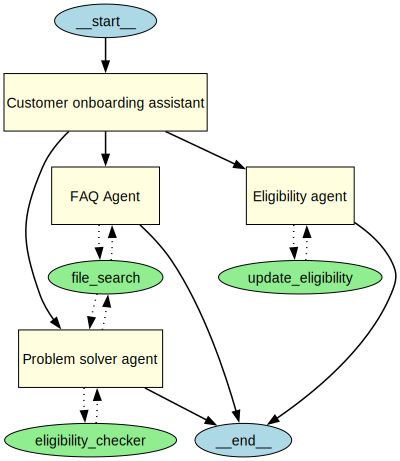

In [65]:
from agents.extensions.visualization import draw_graph

draw_graph(customer_onboarding_agent)

## Tracing

Tracing is available in Agents SDK. You access it on Openai's platform.

In [66]:
from agents import Runner,gen_trace_id, trace

context = UserProfile()

trace_id = gen_trace_id()
with trace("Customer onboarding trace", trace_id=trace_id):
    print(f"View trace: https://platform.openai.com/traces/trace?trace_id={trace_id}")

    conversation = [
        {"role": "user", "content": "Salut, je suis Allemande, j'ai 25 ans et j'ai déjà un compte en France. Je veux ouvrir un compte bancaire."
        "Mais je ne recois pas l'email de confirmation. Comment puis-je résoudre ce problème ?"}
    ]

    result = await Runner.run(customer_onboarding_agent, conversation, context=context)
    print(result.final_output)

View trace: https://platform.openai.com/traces/trace?trace_id=trace_496c8e0afafd465c8c068f18a2b04f84
Pour valider votre éligibilité, j'ai besoin de quelques informations supplémentaires. Pouvez-vous me confirmer votre pays de résidence fiscale ?


### Tracing with LangSmith

You can use the LLMOps platform of your choice with Agents SDK. Here is LangSmith.

In [67]:
from agents import set_trace_processors
from langsmith.wrappers import OpenAIAgentsTracingProcessor

set_trace_processors([OpenAIAgentsTracingProcessor()])



In [68]:
result = await Runner.run(
    starting_agent=customer_onboarding_agent,
    input=result.to_input_list() + [
        {"role": "user", "content": "Je réside fiscalement en France."}
    ],
    context=context
)
result.final_output

"Pour résoudre le problème de non-réception de l'e-mail de confirmation lorsque vous ouvrez un compte bancaire, voici quelques étapes que vous pouvez suivre :\n\n1. **Vérifiez vos dossiers de spam** : Assurez-vous que l'e-mail n'a pas été déplacé dans vos dossiers de courriers indésirables ou spam.\n\n2. **Vérifiez l'adresse e-mail saisie** : Confirmez que l'adresse e-mail que vous avez fournie est correcte. Parfois, une simple faute de frappe peut empêcher la réception de l'e-mail.\n\n3. **Renvoyer l'email** : Si vous n'avez toujours pas reçu l'e-mail, essayez de demander à renvoyer l'e-mail de confirmation depuis l'application ou le site Web de la banque.\n\n4. **Support technique** : Si le problème persiste après ces vérifications, il peut être utile de contacter le support technique de votre banque pour qu'ils puissent examiner cette question plus en détail.\n\nEn suivant ces étapes, vous devriez être en mesure de résoudre le problème. Si vous avez besoin d'aide supplémentaire, n'h

## Dynamic Instructions

You can push information in the context to the prompt with dynamic instructions.

In [69]:
@dataclass
class UserProfile:  
    nationality: str | None = None
    age: int | None = None
    has_eu_bank_account: bool | None = None
    is_elligible: bool | None = None
    onboarding_channel: str | None = None # "mobile" or "web"
    onboarding_step: str | None = None # "not_started", "verify_identity" or "upload_docs"


def problem_solver_dynamic_instructions(
    context: RunContextWrapper[UserProfile], agent: Agent[UserProfile]
) -> str:
    return f"""{RECOMMENDED_PROMPT_PREFIX}
    You are an AI agent in charge of solving onboarding problems encountered by users of an online bank 'mobile' and 'web' applications.
    You only reply if elligibility has been verified.
    You don't use your own knowledge, you only use the FileSearchTool to retrieve information from the database.
    Use eligibility checker tool to verify eligibility.
    The user's name come's form {context.context.onboarding_channel} and stopped at {context.context.onboarding_step}.
    Help them with their questions."""

problem_solver_agent = Agent[UserProfile](
    name="Problem solver agent",
    instructions=problem_solver_dynamic_instructions,
    tools=[
        FileSearchTool(
            max_num_results=3,
            vector_store_ids=[vector_store_problem.id],
        ),
        eligibility_checker
    ],
)

In [77]:
context = UserProfile(onboarding_channel="mobile", onboarding_step="verify_identity", is_elligible=True)

conversation = [
    {"role": "user", "content": "Je veux ouvrir un compte bancaire chez vous."
    "Je ne peux pas scanner ma carte d'identité. Comment puis-je résoudre ce problème ?"}
]

result = await Runner.run(problem_solver_agent, conversation, context=context)

In [78]:
result.final_output

"Pour résoudre le problème de scan de votre carte d'identité, voici quelques suggestions\xa0:\n\n1. **Utilisez un autre appareil\xa0:** Essayez de scanner votre carte d'identité avec un autre téléphone ou une tablette si possible.\n\n2. **Vérifiez les conditions d’éclairage\xa0:** Assurez-vous que la pièce est bien éclairée et que l’appareil photo de votre téléphone n'est pas obstrué.\n\n3. **Nettoyez l'objectif de l’appareil photo\xa0:** Assurez-vous que l'objectif de votre appareil photo est propre afin d'obtenir une image claire.\n\n4. **Mettez à jour l'application\xa0:** Vérifiez que vous utilisez la dernière version de notre application mobile.\n\n5. **Vérifiez pour les autorisations\xa0:** Assurez-vous que l'application a les autorisations nécessaires pour accéder à votre appareil photo.\n\n6. **Rapprochez la carte\xa0:** Tenez la carte à une distance appropriée pour que le texte soit bien focalisé. \n\n7. **Contactez le support client\xa0:** Si aucune des solutions ci-dessus ne 

---

That is our rapid overview of OpenAI's new Agents SDK. We've covered most of the essentials here but there are many other features in the library, and many of the features we included here come with plenty of different ways to use. The SDK is already fairly substantial and certainly worth keeping an eye on.